- Exploring and visualizing datasets;
- Looking at different approaches to implement linear regression models;
- Training regression models that are robust to outliers;
- Evaluating regression models and diagnosing common problems;
- Fitting regression models to nonlinear data.

# Introducing linear regression

Linear regression aims to predict outputs on a continuous scale rather than categorical class labels.

## Simple linear regression

The goal of simple (univariate) linear regression is to model the relationship between a single feature (explanatory variable, $x$) and a continuous-valued target (response value, $y$). The equation of a linear model with one explanatory variable is defined as follows:
$$y=w_1x+b$$
where $b$ is the bias unit.

Linear regression can be understood as finding the best-fitting straight line through the training examples.

## Multiple linear regression

We can generalize the linear regression model to multiple explanatory variables:
$$y=\sum_{i=1}^mw_ix_i+b=w^Tx+b$$

Multiple linear regression can be understood as finding the best-fitting hyperplane through the training examples.

Let's load the dataset we are going to be using.

In [2]:
import pandas as pd
columns = ['Overall Qual','Overall Cond','Gr Liv Area','Central Air','Total Bsmt SF','SalePrice']
df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt',sep='\t',usecols=columns)
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [3]:
df.shape

(2930, 6)

In [4]:
df['Central Air'] = df['Central Air'].map({'N':0,'Y':1})

In [5]:
df.isnull().sum() # There is a missing value

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [6]:
df = df.dropna(axis=0)
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

# Visualizing the important characteristics of a dataset

We are now performing **Exploratory Data Analysis (EDA)**, to detect the presence of outliers, to see the distribution of data and the relationships between features.

Let's firstly visualize the pair-wise correlations between the different features in the dataset.

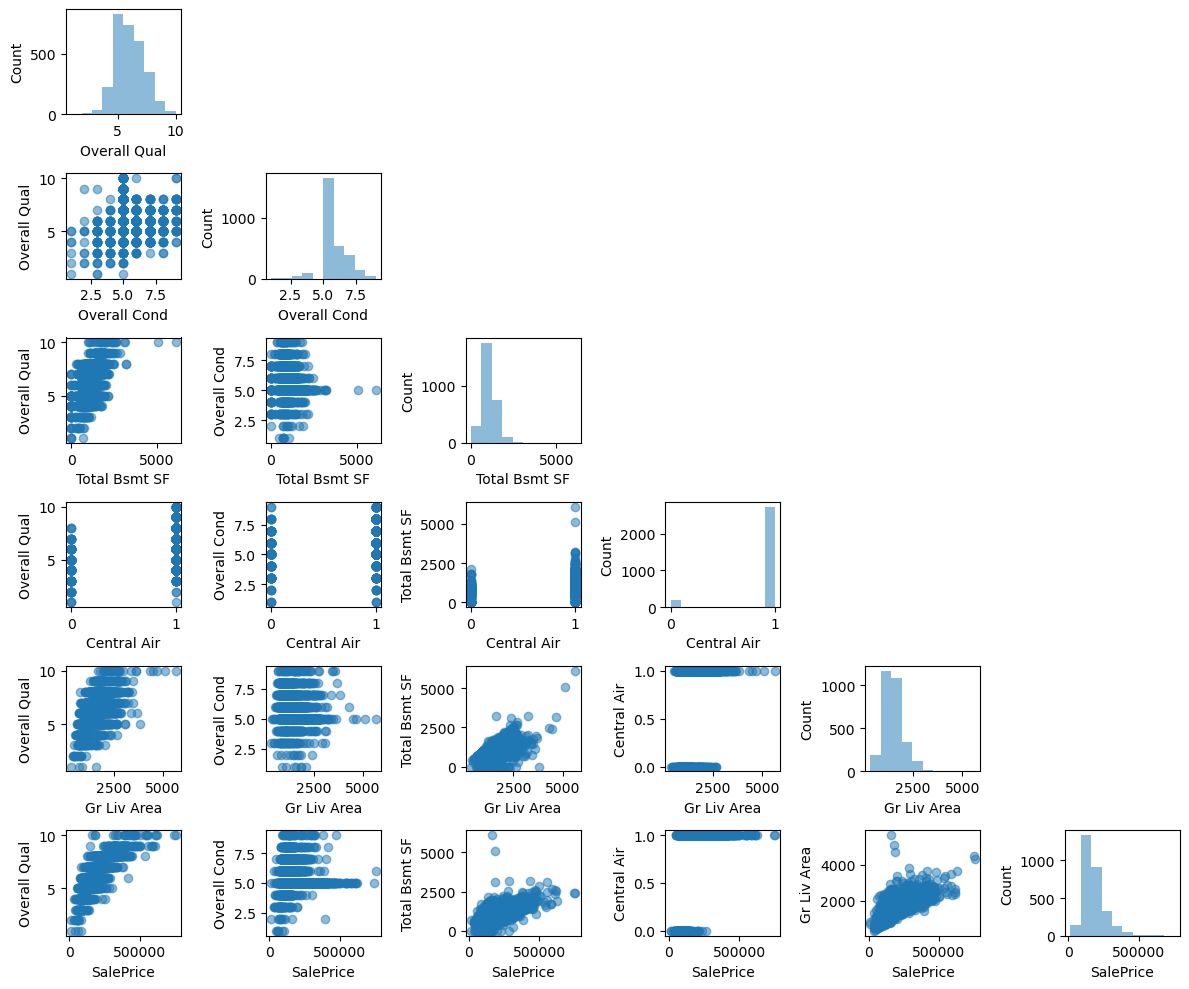

In [7]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
scatterplotmatrix(df.values,figsize=(12,10),names=df.columns,alpha=0.5)
plt.tight_layout()
plt.show()

# Looking at relationships using a correlation matrix

The correlation matrix is a square matrix that contains the *Pearson product-moment correlation coefficient* (abbreviated as Pearson's r) which measures the linear dependence between pairs of features. The correlation coefficients are in the range -1 to 1.
- Perfect correlation = 1;
- Totally uncorrelated = 0;
- Perfect negative correlation = -1.

$$r = \frac{\sum_{i=1}^n[(x^{(i)}-\mu_x)(y^{(i)}-\mu_y)]}{\sqrt{\sum_{i=1}^n(x^{(i)}-\mu_x)^2}\sqrt{\sum_{i=1}^n(y^{(i)}-\mu_y)^2}}=\frac{\sigma_{xy}}{\sigma_x \sigma_y}$$

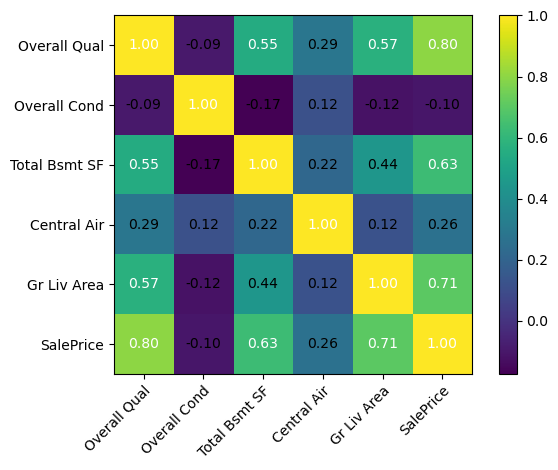

In [8]:
import numpy as np
from mlxtend.plotting import heatmap

cm = np.corrcoef(df.values.T)
hm = heatmap(cm,row_names=df.columns,column_names=df.columns)
plt.tight_layout()
plt.show()

To fit a linear regression model we are interested in those features that have a high correlation with our target variable, SalePrice.

Looking at the previous correlation matrix we can see that Gr Liv Area shows the largest correlation with the Overall Qual variable.

## Solving regression for regression parameters with gradient descent

In [9]:
from linear_regression_gd import LinearRegressionGD

X = df[['Gr Liv Area']].values
y = df['SalePrice'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:,np.newaxis]).flatten()
# Most data preprocessing classes expect data to be stored in tow-dimensional arrays. Here we
# added just a new dimension.
lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std,y_std)

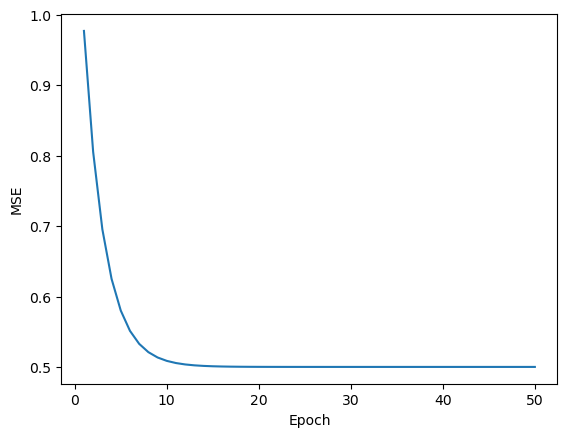

In [10]:
plt.plot(range(1,lr.n_iter+1),lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

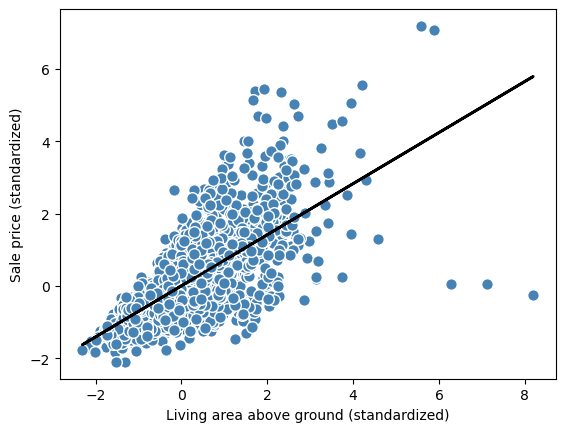

In [11]:
def lin_regplot(X,y,model):
    plt.scatter(X,y,c='steelblue',edgecolor='white',s=70)
    plt.plot(X,model.predict(X),color="black",lw=2)

lin_regplot(X_std,y_std,lr)
plt.xlabel('Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')
plt.show()

In [12]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1,1))
print(f'Sales price: ${target_reverted.flatten()[0]:.2f}')

Sales price: $292507.07


# Estimating the coefficient of a regression model via scikit-learn

The scikit-learn package offers linear regression algorithm more efficient than the one we implemented, not even using the gradient descent, but instead relying on numerical computation through the LAPACK library.

In [13]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X,y)
y_pred = slr.predict(X)
print(f'Slope: {slr.coef_[0]:.3f}')
print(f'Intercept: {slr.intercept_:.3f}')

Slope: 111.666
Intercept: 13342.979


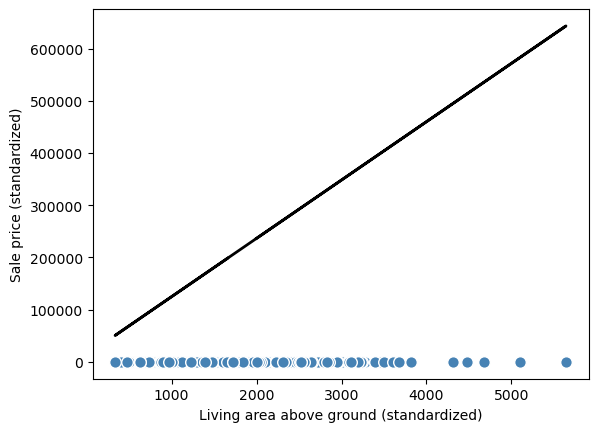

In [14]:
lin_regplot(X,y_std,slr)
plt.xlabel('Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')
plt.show()

# Fitting a robust regression model using RANSAC

Linear regression models can be heavily impacted by the presence of outliers.

Instead of throwing out outliers, we will look at a robust method of regression using the RANdom SAmple Consensus (RANSAC) algorithm:
1. Select a random number of examples to be inliers and fit the model;
2. Test all other data points against the fitted model and add those points that fall within a user-given tolerance to the inliers;
3. Refit the model using all inliers;
4. Estimate the error of the fitted model versus the inliers;
5. Terminate the algorithm if the performance meets a certain user-defined threshold or if a fixed number of iterations was reached; go back to step 1 otherwise.

In [15]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100,
    min_samples=0.95, # Minimum number of randomly sampled data is 95%
    residual_threshold=None,
    random_state=123
)
ransac.fit(X,y)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

The main problem with RANSAC is the choice of the inlier threshold. In this case, using the default method, te **median absolute deviation** is going to be used.
If $M$ is the median:
$$MAD = M(|X - M(X)|)$$

This is done over the $y$ of the dataset, so that determines the range around the model function that establishes what points to take.

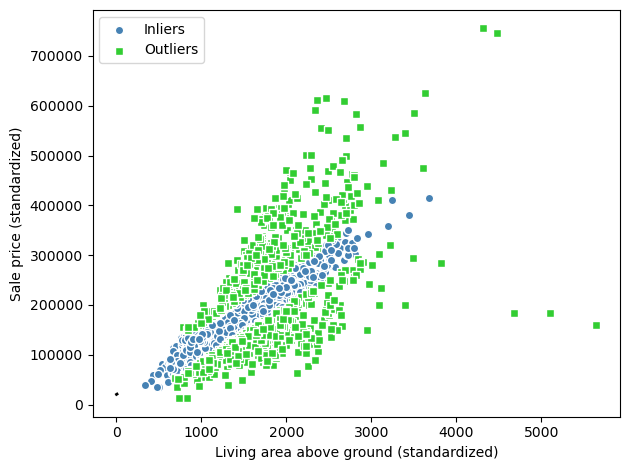

In [16]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3,10,1)
line_y_ransac = ransac.predict(line_X[:,np.newaxis])
plt.scatter(X[inlier_mask],y[inlier_mask],c='steelblue',edgecolor="white",marker='o',label='Inliers')
plt.scatter(X[outlier_mask],y[outlier_mask],c='limegreen',edgecolor="white",marker='s',label='Outliers')
plt.plot(line_X,line_y_ransac,color="black",lw=2)
plt.xlabel('Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


In [17]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 106.348
Intercept: 20190.093


# Evaluating the performance of linear regression models

It is crucial to test the model on data that it hasn't seen during training to obtain a more unbiased estimate of its generalization performance.

In [18]:
from sklearn.model_selection import train_test_split
target = "SalePrice"
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123)
slr=LinearRegression()
slr.fit(X_train,y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

We can't obviously plot the linear regression hyperplane since it's far beyond two dimensions, but what we can do it create a **residual plot**.

They can help to detect nonlinearity and outliers and check whether the errors are randomly distributed.

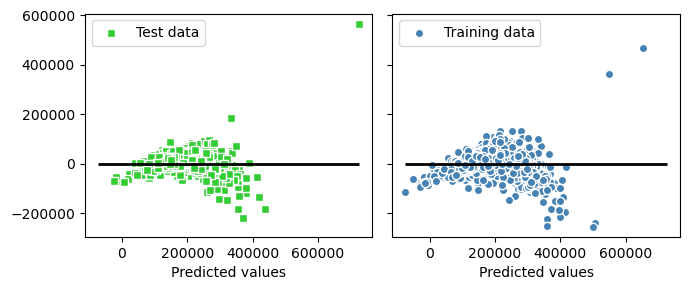

In [19]:
X_max = np.max([np.max(y_train_pred),np.max(y_test_pred)])
X_min = np.min([np.min(y_train_pred),np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3),sharey=True)

ax1.scatter(
    y_test_pred,y_test_pred-y_test,
    c='limegreen', marker="s",
    edgecolor="white",
    label='Test data'
)
ax2.scatter(
    y_train_pred,y_train_pred-y_train,
    c='steelblue', marker="o",
    edgecolor="white",
    label='Training data'
)

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0,xmin=X_min-100,xmax=X_max+100,color="black",lw=2)
plt.tight_layout()
plt.show()

In the case of a perfect prediction the residuals would be exactly zero, so for a good regression model we would expect the errors to be randomly distributed and the residuals to be randomly scattered around the centerline.

Furthermore, we can also use residual plots to detect outliers, which are represented by the points with a large deviation from the centerline.

Another useful quantitative measure of a model's performance is the **mean squared error** (MSE).

In [20]:
# NOTE: in sklearn the MSE automatically normalizes the accuracy by the sample size so that is possible to compare
# performances across different sample sizes.

from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(y_train,y_train_pred)
mse_test = mean_squared_error(y_test,y_test_pred)
print(f'MSE train: {mse_train:.2f}')
print(f'MSE test: {mse_test:.2f}')

MSE train: 1497216245.85
MSE test: 1516565821.00


We can notice that the training set has a lower MSE compared to the test set, which is an indicator of overfitting.

Another metric could be the mean absolute error (MAE).

In [21]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(y_train,y_train_pred)
mae_test = mean_absolute_error(y_test,y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

MAE train: 25983.03
MAE test: 24921.29


Based on the test set MAE we can say that the model makes an error of approximately $25k on average.

Keep in mind that the MSE and the MAE are unbounded in contrast to the classification accuracy. In other words, the interpretations of MAE and MSE depend on the dataset and feature scaling.

Thus, it may sometimes be more useful to report the **coefficient of determination** $R^2$:
$$R^2 = 1 - \frac{SSE}{SST}$$
where, SSE is the sum of squared errors:
$$SSE = \sum_{i=1}^n(y^{(i)}-\hat{y}^{(i)})^2$$
and the SST is the total sum of squares:
$$SST = \sum_{i=1}^n(y^{(i)}-\mu_y)^2$$

For the training dataset the $R^2$ is bounded between 0 and 1, with 0 being that the data is wrongly fitted, and with 1 being that the data is perfectly fitted. However on the test dataset it can go negative.

In [22]:
from sklearn.metrics import r2_score
train_r2 = r2_score(y_train,y_train_pred)
test_r2 = r2_score(y_test,y_test_pred)
print(f"R^2 train: {train_r2:.3f}, R^2 test: {test_r2:.3f}")

R^2 train: 0.769, R^2 test: 0.752


# Using regularized methods for regression

The most popular approaches to regularized linear regression are the so-called:
- **Ridge regression**;
- **Least absolute shrinkage and selection operator (LASSO)**;
- **Elastic net**.
$$L(w)_{Ridge} = \begin{cases}
    \sum_{i=1}^n(y^{(i)}-\hat{y}^{(i)})^2+\lambda\Vert w\Vert^2_2\\
    \lambda \Vert w\Vert^2_2 = \lambda\sum_{j=1}^mw_j^2
\end{cases}$$
$$L(w)_{Lasso} = \begin{cases}
    \sum_{i=1}^n(y^{(i)}-\hat{y}^{(i)})^2+\lambda\Vert w\Vert_1\\
    \lambda \Vert w\Vert_1 = \lambda\sum_{j=1}^m|w_j|
\end{cases}$$
$$L(w)_{Lasso} = \sum_{i=1}^n(y^{(i)}-\hat{y}^{(i)})^2+\lambda_1\Vert w\Vert^2_2+\lambda_2\Vert w\Vert_1\\$$

The lambdas could be optimized through k-fold cross validation.

In [ ]:
# Let's see how could we implement them in sklearn
from sklearn.linear_model import Ridge, Lasso, ElasticNet
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=1.0)
elasticnet = ElasticNet(alpha=1.0,l1_ratio=0.5)

# The polynomial regression chapter result skipped since Jupyter Notebook for Visual Studio Code suck, and I've lost (without the ability to recover them) the related cells.

# Decision tree regression

Instead of using entropy as a measure of impurity, we are now using the MSE instead.

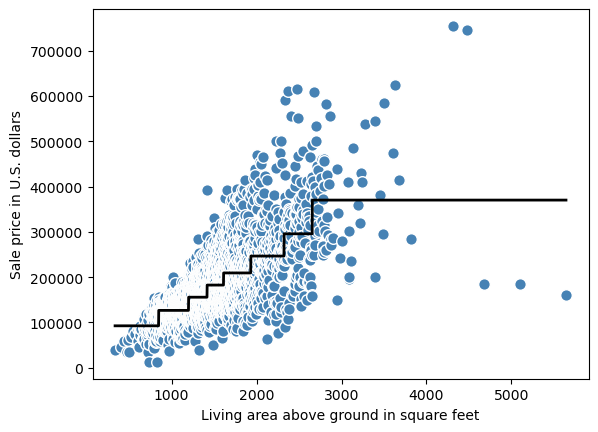

In [29]:
from sklearn.tree import DecisionTreeRegressor
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X,y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx],y[sort_idx],tree)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.show()

The problem with this model is that it doesn't capture the continuitiy and differentiability of the desired prediction. In addition, we need to be careful about choosing an appropriate value for the depth of the tree so as to not overfit or underfit the data.

# Random forest regression

It works, as we know, as an ensemble of trees, resulting in better overall generalization due to randomness. However, the only difference in regression is that the predicted target variable is calculated as the average prediction across al decision trees.

In [31]:
target="SalePrice"
features=df.columns[df.columns!=target]
X=df[features].values
y=df[target].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123)

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000,criterion='squared_error',random_state=1,n_jobs=-1)
forest.fit(X_train,y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
mae_train = mean_absolute_error(y_train,y_train_pred)
mae_test = mean_absolute_error(y_test,y_test_pred)
print(f"MAE train: {mae_train:.2f}")
print(f"MAE test: {mae_test:.2f}")
r2_train = r2_score(y_train,y_train_pred)
r2_test = r2_score(y_test,y_test_pred)
print(f"R^2 train: {r2_train:.2f}")
print(f"R^2 test: {r2_test:.2f}")

MAE train: 8305.26
MAE test: 20823.86
R^2 train: 0.98
R^2 test: 0.85


We can see that the model is overfitting the data. However it tends to perform better on the test dataset compared to the linear regression model of the previous section.

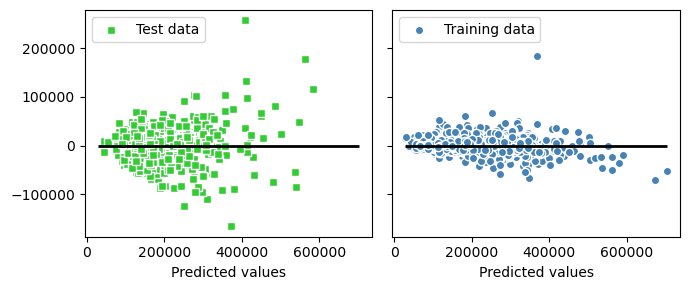

In [32]:
X_max = np.max([np.max(y_train_pred),np.max(y_test_pred)])
X_min = np.min([np.min(y_train_pred),np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3),sharey=True)

ax1.scatter(
    y_test_pred,y_test_pred-y_test,
    c='limegreen', marker="s",
    edgecolor="white",
    label='Test data'
)
ax2.scatter(
    y_train_pred,y_train_pred-y_train,
    c='steelblue', marker="o",
    edgecolor="white",
    label='Training data'
)

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0,xmin=X_min-100,xmax=X_max+100,color="black",lw=2)
plt.tight_layout()
plt.show()

The residual plots here show a large improvement over the residual plot of the linear model that we plotted earlier in the chapter since, ideally, the model error should be random or unpredictable. If we find patterns in the prediction errors, for example, by inspecting the residual plot, it means that the residual plots contain predictive information (as we can clearly see in the residual plots of the simple linear regression).